## Introduction

**Author:** Muhammad Ziko Ananda Setyawan  
**Dataset:** [Coffee Sales Dataset](https://www.kaggle.com/datasets/anassarfraz13/coffee-sales-dataset)

### Objective
This project analyzes coffee sales data to support operational and marketing
decisions for a coffee shop, with a focus on staffing optimization, product
performance, and time-based revenue patterns.

### Business Problem
How can a coffee shop optimize staffing and promotional strategies to:
- Increase transaction frequency by **15% during off-peak hours**
- Increase total revenue of **top 3 products by 10% during peak hours**
within the next 30 days?

### Key Analytical Questions
1. When do peak and off-peak sales occur?
2. Which day–hour combinations generate the highest and lowest revenue?
3. Which coffee products contribute the most to total revenue?
4. Are revenue differences across time of day statistically significant?

# Import Libraries

In [47]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
# Load data yang akan dianalisa dan tampilkan 5 data teratas
df = pd.read_csv("coffee_sales.csv")
df.head(5)

,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000
1,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000
2,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000
3,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000
4,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000


In [3]:
# Menampilkan summary data yang akan dianalisa
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3547 entries, 0 to 3546
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hour_of_day  3547 non-null   int64  
 1   cash_type    3547 non-null   object 
 2   money        3547 non-null   float64
 3   coffee_name  3547 non-null   object 
 4   Time_of_Day  3547 non-null   object 
 5   Weekday      3547 non-null   object 
 6   Month_name   3547 non-null   object 
 7   Weekdaysort  3547 non-null   int64  
 8   Monthsort    3547 non-null   int64  
 9   Date         3547 non-null   object 
 10  Time         3547 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 304.9+ KB


In [ ]:
# Cek Missing Values
df.isnull().sum()

hour_of_day    0
cash_type      0
money          0
coffee_name    0
Time_of_Day    0
Weekday        0
Month_name     0
Weekdaysort    0
Monthsort      0
Date           0
Time           0
dtype: int64

In [ ]:
# Cek duplikat
df.duplicated().sum()

0

# Data Cleaning

In [5]:
# Copy data awal sehingga tidak merubah data awal pada saat pengerjaan
df_clean = df.copy()

In [6]:
# Normalisasi Kolom
df_clean.columns = (
    df_clean.columns
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
)

In [7]:
# Rename Nama kolom agar mempermudah analisa
df_clean = df_clean.rename(columns={
    'money': 'revenue',
    'cash_type': 'payment_method',
    'date': 'date',
    'time': 'time'
})

In [12]:
# Convert date
df_clean['date'] = pd.to_datetime(df_clean['date'])

# Gabungkan date + time → datetime (format campuran)
df_clean['datetime'] = pd.to_datetime(
    df_clean['date'].astype(str) + ' ' + df_clean['time'],
    format='mixed',
    errors='coerce'
)

# Ekstraksi fitur waktu tambahan (kalau belum konsisten)
df_clean['hour'] = df_clean['datetime'].dt.hour
df_clean['day_name'] = df_clean['datetime'].dt.day_name()
df_clean['month'] = df_clean['datetime'].dt.month

In [19]:
print("Nilai unik untuk kolom kategori :")
for col in ['payment_method', 'time_of_day','coffee_name','month_name','weekday']:
    print(f"{col}: {df_clean[col].unique()}")

Nilai unik untuk kolom kategori :
payment_method: ['card']
time_of_day: ['Morning' 'Afternoon' 'Night']
coffee_name: ['Latte' 'Hot Chocolate' 'Americano' 'Americano with Milk' 'Cocoa'
 'Cortado' 'Espresso' 'Cappuccino']
month_name: ['Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec' 'Jan' 'Feb']
weekday: ['Fri' 'Sat' 'Sun' 'Mon' 'Tue' 'Wed' 'Thu']


In [38]:
# Menampilkan statistik deskriptif dari kolom revenue
df_clean['revenue'].describe()

count    3547.000000
mean       31.645216
std         4.877754
min        18.120000
25%        27.920000
50%        32.820000
75%        35.760000
max        38.700000
Name: revenue, dtype: float64

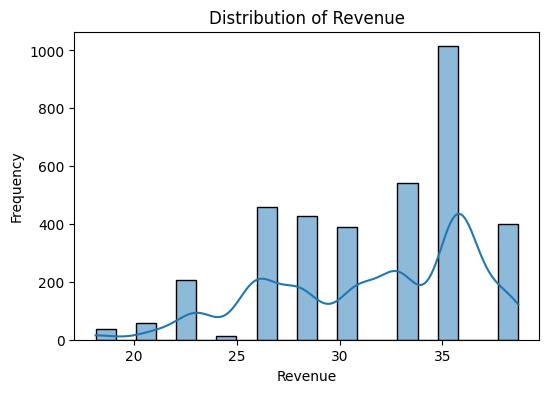

In [40]:
plt.figure(figsize=(6,4))
sns.histplot(df_clean['revenue'], kde=True)
plt.title("Distribution of Revenue")
plt.xlabel("Revenue")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Cek Presentase Outlier
Q1 = df_clean['revenue'].quantile(0.25)
Q3 = df_clean['revenue'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_clean[
    (df_clean['revenue'] < lower_bound) |
    (df_clean['revenue'] > upper_bound)
]

outlier_percentage = len(outliers) / len(df_clean) * 100
outlier_percentage

0.0

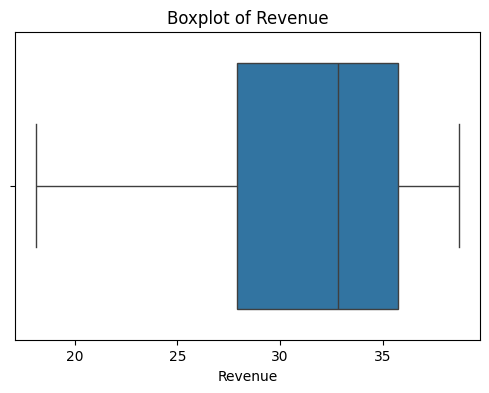

In [42]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_clean['revenue'])
plt.title("Boxplot of Revenue")
plt.xlabel("Revenue")
plt.show()

Berdasarkan hasil analisis menggunakan metode IQR dan visualisasi boxplot, tidak ditemukan transaksi yang berada di luar batas outlier. Hal ini menunjukkan bahwa nilai transaksi relatif homogen dan tidak terdapat transaksi ekstrem yang berpotensi mendistorsi analisis statistik.  

Dengan demikian:
- Tidak dilakukan penghapusan maupun transformasi data terkait outlier.
- Seluruh data transaksi tetap digunakan dalam analisis selanjutnya karena masih valid secara bisnis.

# EXPLORATION DATA ANALYSIS (EDA)

In [72]:
# Setting tema untuk visualisasi data
sns.set_theme(style="whitegrid")
coffee_palette = ["#D2B48C", "#C3B091","#A67B5B","#8B5A2B","#6F4E37"]

## Visualisasi 1
Jam Sibuk dan Jam Sepi Penjualan

Penjabaran masalah:  
Kapan jam sibuk dan jam sepi penjualan kopi terjadi?

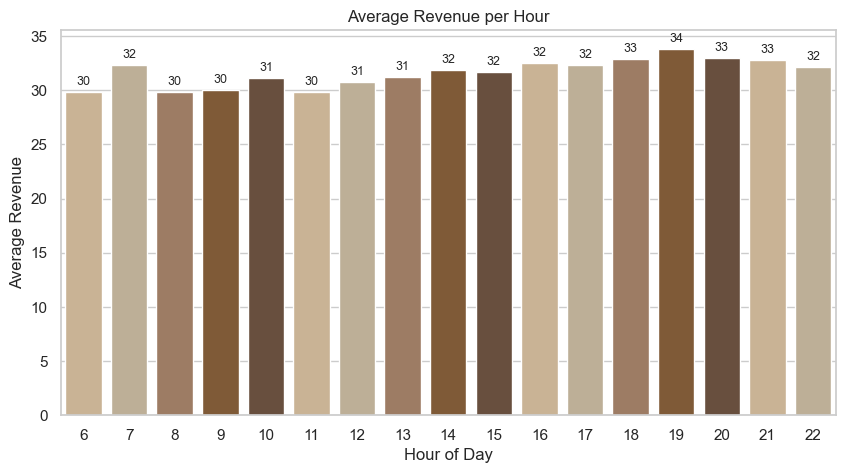

In [73]:
hourly_sales = (
    df_clean
    .groupby('hour_of_day')['revenue']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
ax = sns.barplot(data=hourly_sales, x='hour_of_day', y='revenue', palette=coffee_palette)
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.0f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=9,
        xytext=(0, 3),
        textcoords='offset points'
    )
plt.title('Average Revenue per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Revenue')
plt.show()

Rata-rata revenue per jam menunjukkan bahwa jam sibuk penjualan terjadi pada rentang sore hingga malam hari, khususnya sekitar pukul 18.00–20.00, dengan rata-rata revenue tertinggi berada di kisaran 33–34. Sebaliknya, jam pagi hingga menjelang siang (sekitar pukul 06.00–11.00) cenderung memiliki rata-rata revenue yang lebih rendah, berkisar 29–31, sehingga dapat dikategorikan sebagai jam sepi.

## Visualisasi 2
Pola Penjualan Berdasarkan Hari dan Jam

Penjabaran masalah:  
Kombinasi hari dan jam apa yang menunjukkan aktivitas penjualan tertinggi dan terendah?

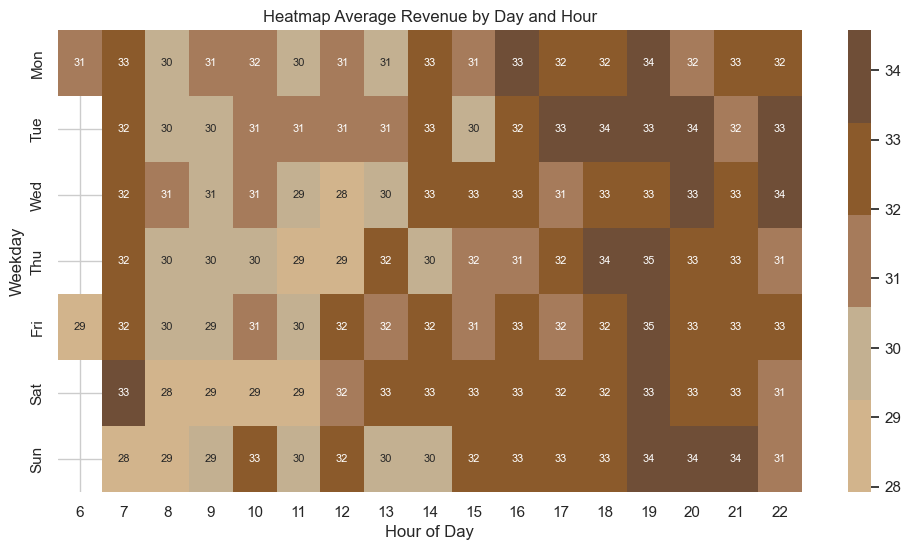

In [75]:
pivot_day_hour = (
    df_clean
    .pivot_table(
        values='revenue',
        index=['weekday', 'weekdaysort'],
        columns='hour_of_day',
        aggfunc='mean'
    )
    .sort_index(level='weekdaysort')
    .droplevel('weekdaysort')
)
coffee_cmap = sns.color_palette(coffee_palette, as_cmap=True)
plt.figure(figsize=(12,6))
sns.heatmap(pivot_day_hour, cmap=coffee_cmap, annot=True,fmt=".0f",annot_kws={"size":8})
plt.title('Heatmap Average Revenue by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Weekday')
plt.show()

Heatmap menunjukkan bahwa pola penjualan tidak hanya dipengaruhi oleh jam, tetapi juga oleh kombinasi hari dan jam. Aktivitas penjualan tertinggi secara konsisten terlihat pada jam sore hingga malam (sekitar pukul 18.00–21.00) di hampir seluruh hari kerja dan akhir pekan. Sebaliknya, jam pagi pada akhir pekan dan awal pekan menunjukkan intensitas revenue yang relatif lebih rendah.

## Visualisasi 3
Distribusi Metode Pembayaran

Penjabaran Masalah:  
Bagaimana distribusi metode pembayaran pada transaksi penjualan kopi?

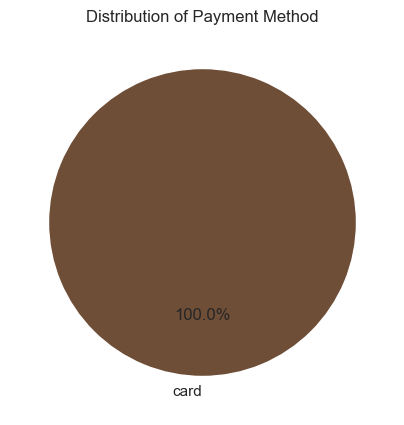

In [76]:
payment_dist = df_clean['payment_method'].value_counts()

plt.figure(figsize=(5,5))
plt.pie(
    payment_dist,
    labels=payment_dist.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#6F4E37'],
    wedgeprops={'edgecolor': 'white'}
)
plt.title('Distribution of Payment Method')
plt.show()

Seluruh transaksi pada dataset menggunakan satu metode pembayaran (card), yang ditunjukkan oleh distribusi 100% pada satu kategori. Hal ini mengindikasikan bahwa tidak terdapat variasi metode pembayaran dalam data transaksi yang dianalisis.

## Visualisasi 4
Produk dengan Kontribusi Revenue Terbesar

Penjabaran Masalah:  
Produk kopi apa saja yang memberikan kontribusi revenue terbesar?

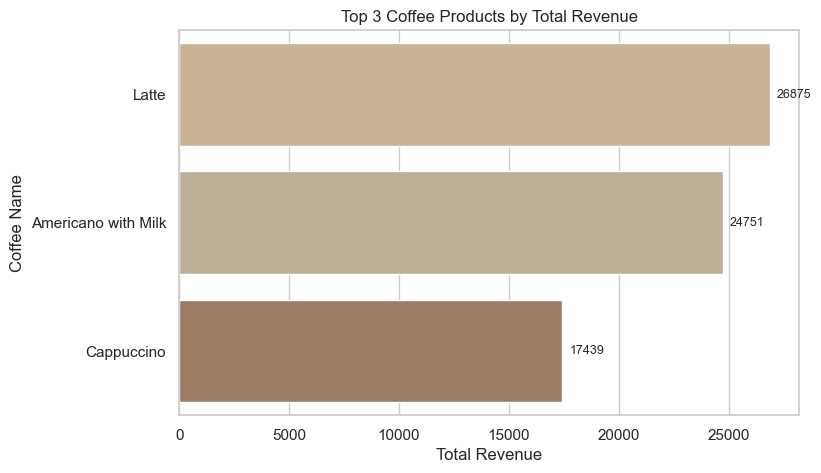

In [ ]:
top_products = (
    df_clean
    .groupby('coffee_name')['revenue']
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .reset_index()
)

plt.figure(figsize=(8,5))
ax = sns.barplot(data=top_products,x='revenue',y='coffee_name',palette=coffee_palette)
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.0f}",
        (p.get_width(), p.get_y() + p.get_height() / 2),
        ha='left', va='center',
        fontsize=9,
        xytext=(5, 0),
        textcoords='offset points'
    )
plt.title('Top 3 Coffee Products by Total Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Coffee Name')
plt.show()

Tiga produk kopi dengan kontribusi revenue tertinggi adalah Latte, Americano with Milk, dan Cappuccino, dengan Latte menjadi kontributor terbesar secara signifikan. Perbedaan total revenue antar ketiga produk ini menunjukkan adanya produk unggulan yang berperan besar dalam total pendapatan coffee shop.

## Statistik Deskriptif
Statistik Deskriptif Revenue

In [84]:
df_clean['revenue'].describe()

count    3547.000000
mean       31.645216
std         4.877754
min        18.120000
25%        27.920000
50%        32.820000
75%        35.760000
max        38.700000
Name: revenue, dtype: float64

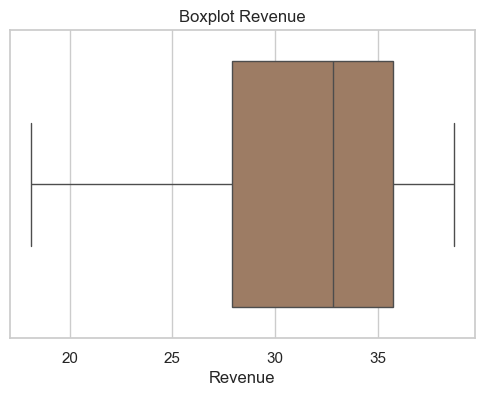

In [88]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_clean['revenue'], color="#A67B5B")
plt.title('Boxplot Revenue')
plt.xlabel('Revenue')
plt.show()

Distribusi revenue menunjukkan variasi nilai transaksi dengan perbedaan antara mean dan median. Namun, tidak ditemukan outlier ekstrem, sehingga seluruh data transaksi tetap digunakan dalam analisis lanjutan.

## Statistik Inferensial
Perbedaan Rata-rata Revenue Berdasarkan Time of Day  
Penjabaran Masalah :  
Apakah terdapat perbedaan rata-rata revenue yang signifikan berdasarkan waktu penjualan?

In [91]:
groups = [
    df_clean[df_clean['time_of_day'] == t]['revenue']
    for t in df_clean['time_of_day'].unique()
]

f_stat, p_value = stats.f_oneway(*groups)
print("f-statistic:",f_stat)
print("p-value:", p_value)

f-statistic: 78.21775635057196
p-value: 5.738878249433681e-34


Hasil uji ANOVA menunjukkan adanya perbedaan rata-rata revenue yang sangat signifikan berdasarkan Time of Day (F = 78.22, p < 0.001). Hal ini mengindikasikan bahwa waktu penjualan memiliki pengaruh yang kuat terhadap pendapatan transaksi

# Conclusion

The analysis shows that both **time of day** and **product type** have a
significant impact on coffee shop revenue.

- Average revenue analysis and day–hour heatmaps reveal consistent peak
  periods between **18:00–20:00**, while morning hours tend to be off-peak.
- ANOVA results confirm that revenue differences across time of day are
  statistically significant (**p < 0.001**), validating that these patterns
  are not random.
- Product analysis indicates that **Latte, Americano with Milk, and Cappuccino**
  are the top contributors to total revenue.
- Payment method analysis shows no variability, limiting its usefulness for
  decision-making.

These findings provide a data-driven foundation for staffing optimization and
time-based promotional strategies.

In [92]:
# Save Dataset 
df_final = df_clean.copy()
df_final.to_csv("coffee_sales_clean.csv", index=False)